In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Mon Aug 21 12:44:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:65:00.0 Off |                  Off |
| 30%   36C    P2    59W / 450W |   3607MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision, torchvision.transforms as transforms

from diffusers import AutoencoderKL

In [4]:
def display_images(tensor, max_per_row=6):
    """Displays a grid of images with at most max_per_row images per row.

    Args:
        tensor (torch.Tensor): A tensor of shape (n_images, 3, 32, 32) containing the images.
        max_per_row (int): The maximum number of images to display per row.
    """
    n_images, channels, height, width = tensor.shape
    assert channels == 3, "Expected 3 channels (RGB) in the input tensor"

    # Set tensor to cpu
    if tensor.is_cuda:
        tensor = tensor.cpu()
    
    # Calculate the number of rows and columns required for the grid
    n_rows = (n_images // max_per_row) + int(n_images % max_per_row > 0)
    n_cols = min(max_per_row, n_images)

    # Create a figure and set the size to fill the jupyter cell output
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    # Adjust the spacing between subplots to reduce gaps
    plt.subplots_adjust(wspace=0.02, hspace=0.05)

    # Flatten the axes array and remove any extra unused axes
    axes = axes.flatten()
    for ax in axes[n_images:]:
        ax.axis('off')

    # Iterate through images and display them on the grid
    for i in range(n_images):
        ax = axes[i]
        image = tensor[i].permute(1, 2, 0).numpy()  # Permute the image to the shape (32, 32, 3)
        image_min, image_max = image.min(), image.max() # normalize image's pixel values
        image = (image - image_min) / (image_max - image_min) if image_max > image_min else image
        ax.imshow(image)
        ax.axis('off')

    plt.show()

In [5]:
def save_model_architecture(filepath, model):
    with open(filepath, 'w') as f:
        f.write(str(model))

def write_to_file(filepath, text):
    with open(filepath, 'a') as file:
        file.write(text + '\n')

# Cifar10

Get pretrained vae.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-2", subfolder="vae")
vae = vae.to(device)

In [7]:
!nvidia-smi

Mon Aug 21 12:44:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:65:00.0 Off |                  Off |
| 30%   36C    P2    59W / 450W |   4769MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Get cifar10 dataset.

In [7]:
image_size = 32

preprocess_images = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

cifar10_tensor = torch.stack([x[0] for x in torchvision.datasets.CIFAR10(root='./data', transform=preprocess_images, download=True)]).to(device)

Files already downloaded and verified


In [8]:
cifar10_tensor.size()

torch.Size([50000, 3, 32, 32])

## (SKIP HERE) Load cifar10 latents

In [8]:
save_path = "data/cifar10_latents.pth"
cifar10_latents = torch.load(save_path)

# Reconstruction w/ Pretrained VAE

In [28]:
def print_data_range(tensor):
        tensor_min, tensor_max = tensor.min().item(), tensor.max().item()
        print(f"Data range: ({tensor_min}, {tensor_max})")

def normalize_to_range(tensor, min_val=-1.0, max_val=1.0):
    tensor_min, tensor_max = tensor.min(), tensor.max()
    tensor -= tensor_min # shift old range so min is 0
    tensor *= (max_val - min_val) / (tensor_max - tensor_min) # change to new range
    tensor += min_val # shift to new range
    return tensor

def reconstruct_with_vae(vae, image_tensor):
    """ image_tensor has shape (n_images, n_channels, width, height) """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vae.to(device)
    image_tensor = image_tensor.to(device)
    print("Original image tensor:")
    print(f"Shape: {image_tensor.shape}")
    print_data_range(image_tensor)

    # Encoding images to latent space
    latents = []
    for sample in tqdm(image_tensor, desc="Encoding images to latent codes", ncols=100):
        with torch.no_grad():
            latent_dist = vae.encode(sample.unsqueeze(0)).latent_dist
            latent = latent_dist.sample()
            latents.append(latent)
    latents = torch.cat(latents, dim=0)
    print("Latent codes:")
    print(f"Shape: {latents.shape}")
    print_data_range(latents)

    # Decoding latents to reconstruct images
    reconstructed = []
    for latent in tqdm(latents, desc="Decoding latent codes to images", ncols=100):
        with torch.no_grad():
            reconstructed_image = vae.decode(latent.unsqueeze(0)).sample
            reconstructed.append(reconstructed_image)
    reconstructed = torch.cat(reconstructed, dim=0)
    print("Reconstructed images:")
    print(f"Shape: {reconstructed.shape}")
    print_data_range(reconstructed)

    # Normalize reconstructions
    reconstructed_normalized = normalize_to_range(reconstructed)
    print("Normalized reconstructed images:")
    print(f"Shape: {reconstructed_normalized.shape}")
    print_data_range(reconstructed_normalized)
    
    return reconstructed_normalized

In [31]:
cifar10_reconstructed = reconstruct_with_vae(vae, cifar10_tensor)

Original image tensor:
Shape: torch.Size([50000, 3, 32, 32])
Data range: (-1.0, 1.0)


Encoding images to latent codes: 100%|███████████████████████| 50000/50000 [02:42<00:00, 308.44it/s]


Latent codes:
Shape: torch.Size([50000, 4, 4, 4])
Data range: (-18.066041946411133, 19.457595825195312)


Decoding latent codes to images: 100%|███████████████████████| 50000/50000 [03:28<00:00, 239.31it/s]


Reconstructed images:
Shape: torch.Size([50000, 3, 32, 32])
Data range: (-4.007981777191162, 3.9366812705993652)
Normalized reconstructed images:
Shape: torch.Size([50000, 3, 32, 32])
Data range: (-1.0, 1.0)


Calculate reconstruction error, using l1 loss.

In [39]:
# Compute the L1 reconstruction loss
reconstruction_error_sum = nn.L1Loss(reduction='sum')(cifar10_tensor, cifar10_reconstructed)

# Normalize the reconstruction loss by the total number of elements
total_elements = cifar10_tensor.numel()
normalized_reconstruction_error = reconstruction_error_sum / total_elements

print(f"Summed Reconstruction Loss: {reconstruction_error_sum}")
print(f"Normalized Reconstruction Loss: {normalized_reconstruction_error.item()}")

Summed Reconstruction Loss: 48693724.0
Normalized Reconstruction Loss: 0.3170164227485657


Reconstruction steps:
- encode image tensor to a latent gaussian distribution using the vae's encoder
- randomly sample from this latent distribution
- decode the sampled latent vector to reconstruct the image

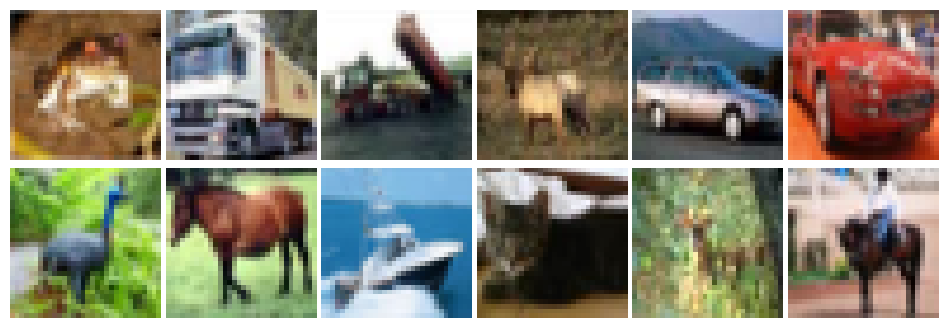

In [40]:
display_images(cifar10_tensor[:12])

In [48]:
with torch.no_grad():
    recon = vae(cifar10_tensor[:12]).sample

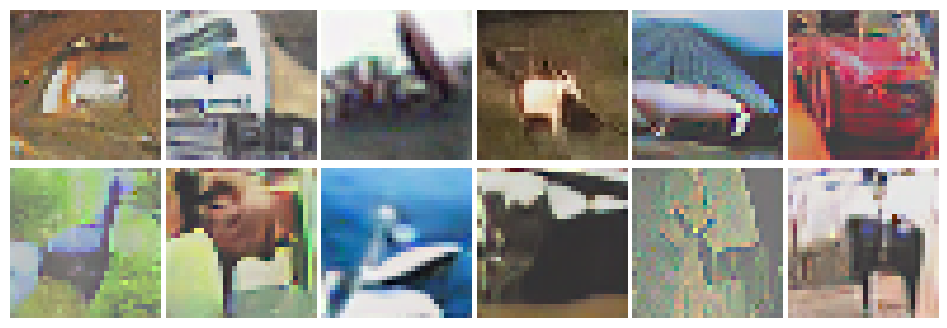

In [49]:
display_images(recon)

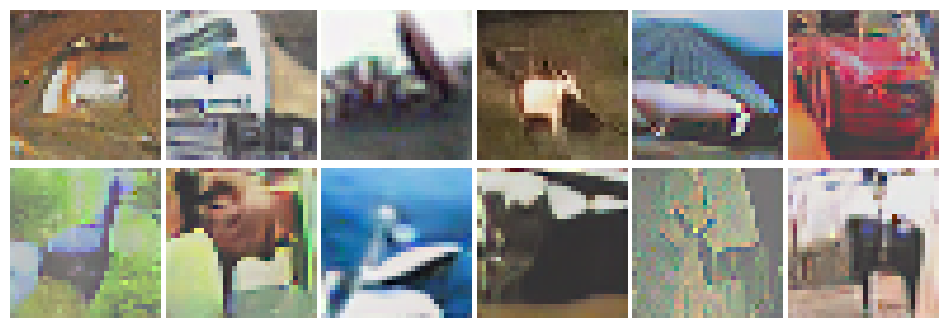

In [50]:
display_images(cifar10_reconstructed[:12])

For some reason stable diffusion's vae is just not reconstructing well - perhaps has to do with sampling from the latent dist instead of directly getting latents?

# High Quality (Joke) Cifar10

Perhaps it has to do with the stable diffusion vae being trained on high quality images?

In [8]:
preprocess_images = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
cifar10_512_dataset = torchvision.datasets.CIFAR10(root='./data', transform=preprocess_images, download=True)

cifar10_512_list = []
for i in range(100):
    cifar10_512_list.append(cifar10_512_dataset[i][0])
cifar10_512_tensor = torch.stack(cifar10_512_list).to(device)

Files already downloaded and verified


In [9]:
cifar10_512_tensor.size()

torch.Size([100, 3, 512, 512])

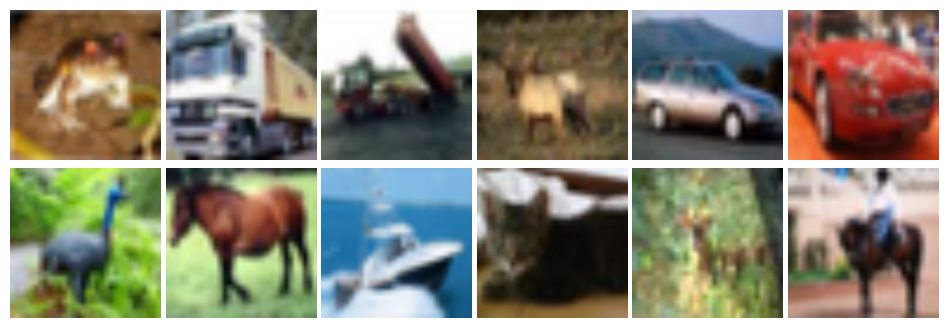

In [12]:
display_images(cifar10_512_tensor[:12])

In [15]:
cifar10_512_recons = []
for i in range(100):
    with torch.no_grad():
        recon = vae(cifar10_512_tensor[i].unsqueeze(0)).sample
    cifar10_512_recons.append(recon)
cifar10_512_recons = torch.cat(cifar10_512_recons, dim=0)

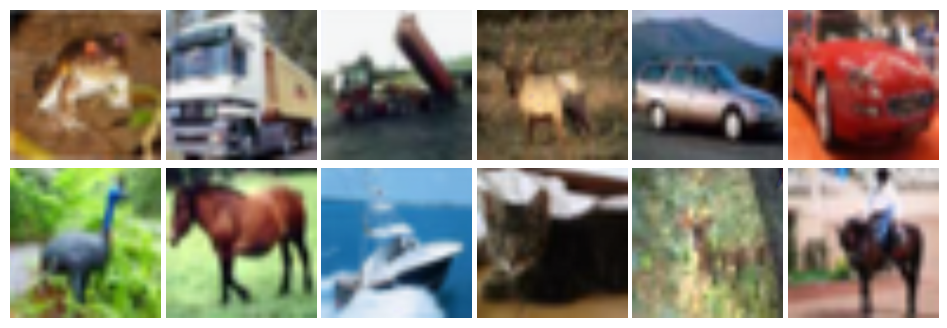

In [18]:
display_images(cifar10_512_recons[:12])

In [19]:
# Compute the L1 reconstruction loss
reconstruction_error_sum = nn.L1Loss(reduction='sum')(cifar10_512_tensor, cifar10_512_recons)

# Normalize the reconstruction loss by the total number of elements
total_elements = cifar10_512_tensor.numel()
normalized_reconstruction_error = reconstruction_error_sum / total_elements

print(f"Summed Reconstruction Loss: {reconstruction_error_sum}")
print(f"Normalized Reconstruction Loss: {normalized_reconstruction_error.item()}")

Summed Reconstruction Loss: 1361690.5
Normalized Reconstruction Loss: 0.017314789816737175


# EBM Architecture

MLP

In [52]:
n_channels = 4
latent_size = 4
leaky_slope = 0.2

class EnergyFunction(nn.Module):
    def __init__(self, input_dim=n_channels * latent_size * latent_size, l=leaky_slope):
        super(EnergyFunction, self).__init__()
        
        # Neural network representing the energy function
        self.f = nn.Sequential(
            # Input: (n_channels x 4 x 4)
            nn.Flatten(),
            
            nn.Linear(input_dim, 128),          # 64 -> 128
            nn.LeakyReLU(l),

            nn.Linear(128, 256),          # 128 -> 256
            nn.LeakyReLU(l),

            nn.Linear(256, 1),          # 256 -> 1
        )
        
    def forward(self, x):
        return self.f(x).squeeze()

energy_func = EnergyFunction().to(device)

Conv

In [53]:
# n_channels = 4
# n_features = 64
# leaky_slope = 0.2

# class EnergyFunction(nn.Module):
#     def __init__(self, n_c=n_channels, n_f=n_features, l=leaky_slope):
#         super(EnergyFunction, self).__init__()
        
#         # Neural network representing the energy function
#         # Conv2d(in_channels, out_channels, kernel_size, stride, padding
#         self.f = nn.Sequential(
#             # Input: (n_channels x 4 x 4)
#             nn.Conv2d(n_c, n_f, 3, 1, 1),          # 4x4 -> 4x4 (due to padding of 1)
#             nn.LeakyReLU(l),

#             nn.Conv2d(n_f, n_f*2, 3, 1, 1),          # 4x4 -> 4x4 (due to padding of 1)
#             nn.LeakyReLU(l),
            
#             nn.Conv2d(n_f*2, 1, 4, 1, 0)         # 4x4 -> 1x1
#         )
        
#     def forward(self, x):
#         return self.f(x).squeeze()

# energy_func = EnergyFunction().to(device)

# EBM Training

Sampling using energy function's learned data distribution and MCMC.

In [63]:
latent_size = 4
m = 64           # Mini-batch size
K = 100          # Number of steps of MCMC

# Function to add Gaussian noise to data
def add_noise_to_data(data, sigma):
    return data + sigma * torch.randn_like(data)

# Sample from the preprocessed data distribution and add Gaussian noise
def sample_from_data_distribution(data_tensor, sigma):
    random_indices = torch.LongTensor(m).random_(0, data_tensor.shape[0])
    latents = []
    for sample in data_tensor[random_indices]:
        with torch.no_grad():
            latent_dist = vae.encode(sample.unsqueeze(0)).latent_dist
            latent = latent_dist.sample()
            latents.append(latent)
    latents = torch.cat(latents, dim=0)
    return add_noise_to_data(latents, sigma).detach()

# # Generate random noise
# def generate_noise():
#     return torch.FloatTensor(m, n_channels, latent_size, latent_size).uniform_(-1, 1).to(device)

# Sample using short-run MCMC from the model's distribution
def sample_from_model(f, K=K):
    noise = torch.FloatTensor(m, n_channels, latent_size, latent_size).uniform_(-1, 1).to(device)
    samples = torch.autograd.Variable(noise, requires_grad=True)  # Create initial samples with noise and set requires_grad=True for gradient computation
    
    for _ in range(K):
        gradient = torch.autograd.grad(energy_func(samples).sum(), [samples], retain_graph=True)[0]  # Compute gradient of summed energy over all samples
        samples.data += gradient + 1e-2 * torch.randn_like(samples)                                  # Move towards gradient and add additional noise
        
    return samples.detach()  # Detach the tensor from the computation graph

## Training Loop

Create logging and save architecture in text file.

In [64]:
model_name = "ebm_128x256_mlp"

model_train_dir = os.path.join("training", model_name)
if not os.path.exists(model_train_dir):
    os.makedirs(model_train_dir)

model_image_dir = os.path.join(model_train_dir, "ebm_images")
if not os.path.exists(model_image_dir):
    os.makedirs(model_image_dir)

model_arch_file = os.path.join(model_train_dir, "architecture.txt")
model_log_file = os.path.join(model_train_dir, "logs.txt")
model_weights_file = os.path.join(model_train_dir, "weights.pth")
model_train_status_file = os.path.join(model_train_dir, "train_status.json")

save_model_architecture(model_arch_file, energy_func)

In [65]:
def plot_images(path, images):
    torchvision.utils.save_image(torch.clamp(images, -1., 1.), 
                                 path, 
                                 normalize=True, 
                                 nrow=int(torch.sqrt(torch.Tensor([m]))))

Using the loss in training loop as a value for early stopping isn't good because it varies too much.

In [66]:
def load_train_status_json(file_path):
    try:
        with open(file_path, 'r') as file:
            train_status = json.load(file)
            prev_iter = train_status['prev_iter']
    except FileNotFoundError:
        prev_iter = 0
    
    return prev_iter

In [67]:
def save_train_status_json(file_path, curr_iter):
    train_status = {
        'prev_iter': curr_iter
    }
    with open(file_path, 'w') as file:
        json.dump(train_status, file)

Training loop.

In [70]:
lr = 1e-5
sigma = 3e-2     # decrease until training is unstable
optimizer = torch.optim.Adam(energy_func.parameters(), lr=lr, betas=[.9, .999])

# Load in from previous training loops
if os.path.exists(model_weights_file) and os.path.exists(model_train_status_file):
    energy_func.load_state_dict(torch.load(model_weights_file))
    prev_iter = load_train_status_json(model_train_status_file)
else:
    prev_iter = 0
n_iters = 100

# train
for i in range(prev_iter, prev_iter + n_iters):
    real_samples = sample_from_data_distribution(cifar10_tensor, sigma)
    model_samples = sample_from_model(energy_func)
    
    # Compute loss as the difference in energy values of real and model samples
    loss = energy_func(real_samples).mean() - energy_func(model_samples).mean()

    # Backpropagation and optimization
    optimizer.zero_grad()
    (-loss).backward() # MLE, min -loss = max loss
    optimizer.step()

    # Save train status and weights
    save_train_status_json(model_train_status_file, i)
    torch.save(energy_func.state_dict(), model_weights_file)

    # Logging and visualization
    if i % 100 == 0:
        log_text = f'Iteration {i} | Real Sample Energy: {energy_func(real_samples).mean()} | Model Sample Energy: {energy_func(model_samples).mean()}'
        print(log_text)
        write_to_file(model_log_file, log_text)
        plot_images(f'{model_image_dir}/output_images_{i}.png', model_samples)

Iteration 5800 | Real Sample Energy: 5.966371059417725 | Model Sample Energy: 6.195219993591309


# Generation

In [71]:
def generate_images(n_generations, energy_func=energy_func, vae=vae):
    batch = sample_from_model(energy_func)
    with torch.no_grad():
        decoded_batch = vae.decode(batch).sample
    
    return decoded_batch[:n_generations]

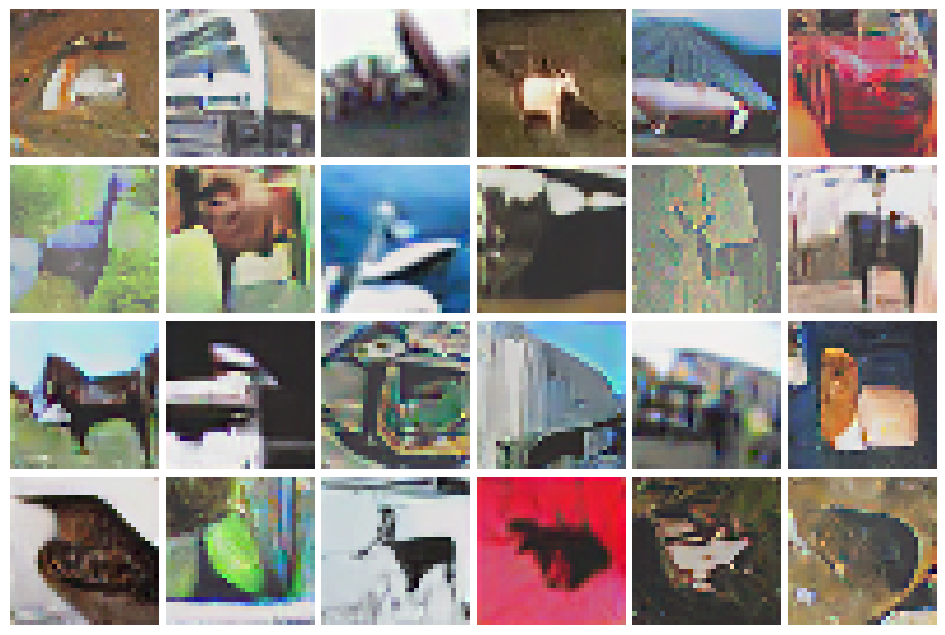

In [72]:
display_images(cifar10_reconstructed[:24])

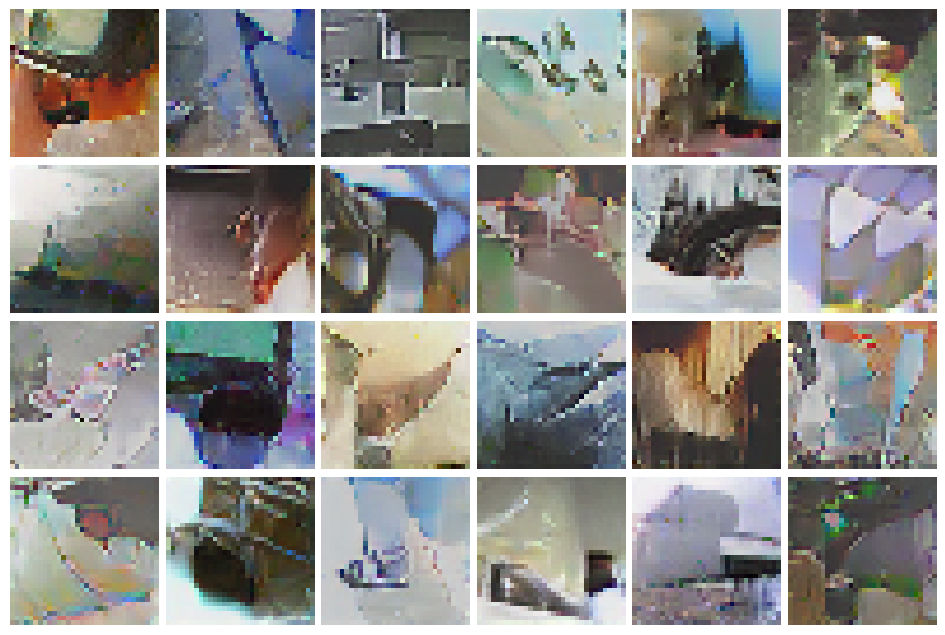

In [73]:
display_images(generate_images(24))